# NN Model IV
- Include Weather And Time Embedding
- Include Pokemon Type Embedding

In [27]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import plot_model

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from kedro.extras.datasets.pandas import CSVDataSet

### Loading Data

In [4]:
BattleResults = catalog.load('Battle_Results')
WeaknessPokemon = catalog.load('Weakness_Pokemon')
AllPokemons = catalog.load('All_Pokemons')

2020-05-26 13:47:21,969 - kedro.io.data_catalog - INFO - Loading data from `Battle_Results` (CSVDataSet)...
2020-05-26 13:47:24,735 - kedro.io.data_catalog - INFO - Loading data from `Weakness_Pokemon` (CSVDataSet)...
2020-05-26 13:47:24,738 - kedro.io.data_catalog - INFO - Loading data from `All_Pokemons` (CSVDataSet)...


In [5]:
BattleResults.head()

,Name_1,Level_1,Price_1,HP_1,Attack_1,Defense_1,Sp_Atk_1,Sp_Def_1,Speed_1,Legendary_1,...,Price_2,HP_2,Attack_2,Defense_2,Sp_Atk_2,Sp_Def_2,Speed_2,Legendary_2,WeatherAndTime,BattleResult
0,Metapod,30,441,150,36,103,47,47,58,False,...,1589,262,393,306,164,211,253,False,Windy,-262
1,Pinsir,36,1227,196,304,237,129,164,197,False,...,1583,547,127,365,172,172,200,False,Unknown,-424
2,Metapod,15,297,92,26,73,33,33,40,False,...,4913,821,1208,947,504,652,781,False,Windy,-821
3,Pinsir,40,1401,228,346,270,146,187,224,False,...,588,202,47,138,63,63,75,False,Unknown,214
4,Pinsir,12,634,91,157,124,70,86,106,False,...,381,126,32,90,41,41,51,False,Windy,41


### Data Pipeline Auxilliary Functions

In [17]:
def RelativeResult(X):
    HP = X.apply(lambda row: row["HP_1"] if row["BattleResult"] > 0 else row["HP_2"], axis=1).values
    relativized = X["BattleResult"].values / HP
    return relativized

y = RelativeResult(BattleResults)

In [13]:
class LevelScaler(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return X / 99

In [94]:
class AddInverse(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return X

In [100]:
class AddPokemonTypes(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.type_attributes = ['Type_1_1', 'Type_1_2', 'Type_2_1', 'Type_2_2']
        self.NametoIndex = {sys.intern(name): AllPokemons.loc[AllPokemons["Name"]==name].iloc[0].ID-1 for name in AllPokemons.Name}
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, df):
        # Values for faster processing
        values = df.values
        AllPokemonTypes = AllPokemons.loc[:,['Type_1', 'Type_2']]
        AllPokemonTypes.Type_2 = AllPokemons.Type_2.fillna(AllPokemons.Type_1)
        AllPokemonTypes = AllPokemonTypes.values
        
        # Old Column indexes
        name1_idx = df.columns.get_loc("Name_1")
        name2_idx = df.columns.get_loc("Name_2")

        # New Columns
        Types = np.empty((len(df),4), dtype='U15')

        for i in range(len(df)):
            idx_1 = self.NametoIndex[values[i,name1_idx]]
            idx_2 = self.NametoIndex[values[i,name2_idx]]

            # Types
            Types[i, 0] = AllPokemonTypes[idx_1, 0]
            Types[i, 1] = AllPokemonTypes[idx_1, 1]
            Types[i, 2] = AllPokemonTypes[idx_2, 0]
            Types[i, 3] = AllPokemonTypes[idx_2, 1]

        
        # Add columns
        df[self.type_attributes] = pd.DataFrame(Types, index=df.index)
        return df

### Data Pipeline Transformation

In [18]:
BattleResults_train, BattleResults_val, y_train, y_val  = train_test_split(BattleResults, y, test_size=0.2, random_state=42)

In [101]:
numerical_attributes = ['HP_1', 'Attack_1', 'Defense_1', 'Sp_Atk_1', 'Sp_Def_1', 'Speed_1', 
                          'HP_2', 'Attack_2', 'Defense_2', 'Sp_Atk_2', 'Sp_Def_2', 'Speed_2']
type_attributes = ['Type_1_1', 'Type_1_2', 'Type_2_1', 'Type_2_2']
TypeEncoder = OrdinalEncoder()

full_pipeline = Pipeline([
    ("Add Types", AddPokemonTypes()),
    ("Data Augmentation", AddInverse()),
    ("Individual Feature Preprocessing", ColumnTransformer([
        ("Drop", "drop", ['Name_1', 'Name_2', 'Price_1', 'Price_2']),
        ("Numerical Attributes", StandardScaler(), numerical_attributes),
        ("Boolean", "passthrough", ['Legendary_1', 'Legendary_2']),
        ("Level" , LevelScaler(), ['Level_1', 'Level_2']),
        ("Weather", OrdinalEncoder(), ['WeatherAndTime']),
        ("Types", TypeEncoder, ['Type_1_1', 'Type_2_1'])
    ])),
])
full_pipeline.fit(BattleResults_train); #battle_data

/home/joel/.local/share/virtualenvs/pokethon-gj-dbL-j/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [102]:
x_train = full_pipeline.transform(BattleResults_train)
x_val = full_pipeline.transform(BattleResults_val)

/home/joel/.local/share/virtualenvs/pokethon-gj-dbL-j/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/joel/.local/share/virtualenvs/pokethon-gj-dbL-j/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [104]:
x_train[5]

array([-9.26792832e-01, -8.45974285e-01, -8.24229147e-01, -8.56687095e-01,
       -8.52412220e-01, -8.85570128e-01, -1.11030577e+00, -1.02142222e+00,
       -8.28406241e-01, -8.11180888e-01, -1.09583165e+00, -8.97785717e-01,
        0.00000000e+00,  0.00000000e+00,  1.01010101e-02,  7.07070707e-02,
        1.00000000e+00,  1.10000000e+01,  1.40000000e+01])

### Functional Model

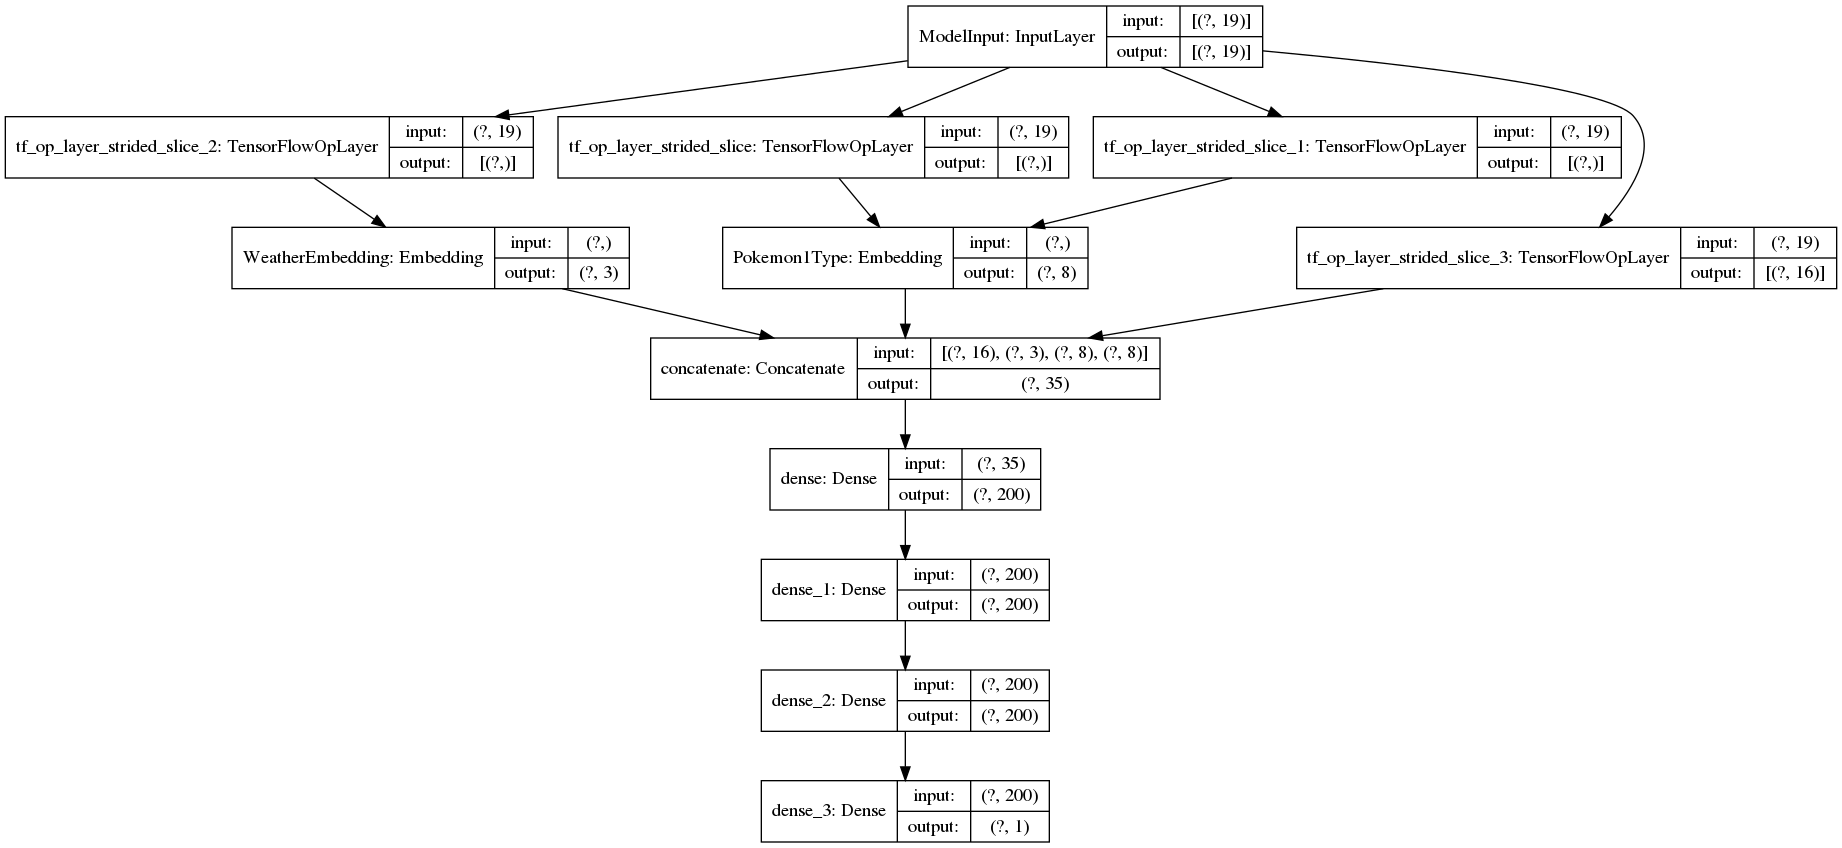

In [105]:
# Functional Model Architecture
""" Input columns are as follows:
- input[0:16] are numerical attributes
- input[16] is Ordinal WeatherAndTime
- input[17] is Ordinal Pokemon_1 First Nature
- input[18] is Ordinal Pokemon_2 First Nature
"""
model_input = layers.Input(shape=(19,), name='ModelInput')
type_emb = layers.Embedding(input_dim=18, output_dim=8, name="Pokemon1Type")
type_emb_1 = type_emb(model_input[:,17])
type_emb_2 = type_emb(model_input[:,18])
weather_emb = layers.Embedding(input_dim=5, output_dim=3, name="WeatherEmbedding")(model_input[:, 16])
x = layers.Concatenate()([model_input[:, 0:16], weather_emb, type_emb_1, type_emb_2])
x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(200, activation='relu')(x)
model_output = layers.Dense(1, activation='tanh')(x)

model = keras.Model(inputs=model_input, outputs=model_output)
plot_model(model, show_shapes=True)

- With Level and and Legendary 0.12

In [106]:
model.compile(loss='mse',
              optimizer=keras.optimizers.RMSprop(learning_rate=3e-3),
              metrics=['RootMeanSquaredError'])

### Train

In [107]:
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_val, y_val),
                    batch_size=1024)

Epoch 1/20
2125/2125 [==============================] - 12s 6ms/step - loss: 0.0434 - root_mean_squared_error: 0.2083 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1598
Epoch 2/20
2125/2125 [==============================] - 12s 6ms/step - loss: 0.0234 - root_mean_squared_error: 0.1531 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494
Epoch 3/20
2125/2125 [==============================] - 11s 5ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 4/20
2125/2125 [==============================] - 11s 5ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 5/20
2125/2125 [==============================] - 12s 6ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 6/20
2125/2125 [==============================] - 12s 6ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_l